<a href="https://colab.research.google.com/github/Garethlomax/CI/blob/master/Gareth_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, KMNIST

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    

Cuda installed! Running on GPU!


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


# VAE


In [26]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder
        self.linear1 = nn.Linear(1*28*28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3_mu = nn.Linear(256, 2) # could go BIGGER 
        self.linear3_logvar = nn.Linear(256, 2) # changed from 4, # changed to 10, switch to subscript 100 - for the net. 
        # decoder
        self.linear4 = nn.Linear(2, 256)
        self.linear5 = nn.Linear(256, 512)
        self.linear6 = nn.Linear(512, 1*28*28)
        
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x):
        h = self.activation(self.linear1(x))
        h = self.activation(self.linear2(h))
        
        mu = self.linear3_mu(h)
        logvar = self.linear3_logvar(h)
        return mu, logvar
    
    def latent_space(self, mu, log_var):
        if self.training:
          std = torch.exp(0.5*log_var)
          eps = torch.randn_like(std).to(device)
          z = eps.mul(std).add_(mu) 
        else:
          z = mu
        return z
        
    def decoder(self, z):
        h = self.activation(self.linear4(z))
        h = self.activation(self.linear5(h))
        reconstruction = self.sigmoid(self.linear6(h)) 
        return reconstruction
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.latent_space(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction.view(-1, 1, 28, 28), z, mu, log_var

# build model
x = torch.randn((1, 1, 28, 28)).to(device)
model = VAE().to(device)
x_, z, mu, logvar = model(x)
print(x_.size(), z.size(), mu.size(), logvar.size())


torch.Size([1, 1, 28, 28]) torch.Size([1, 2]) torch.Size([1, 2]) torch.Size([1, 2])


# KMNIST

In [27]:
mnist_train_dset = KMNIST("./", download=True, train=True)
mnist_test_dset = KMNIST("./", download=True, train=False)

from torch.utils.data import Dataset 

class CustomVAETensorDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = sample.view(1, 28, 28).float()
        sample /= 255.

        return sample

mnist_train = CustomVAETensorDataset(mnist_train_dset.train_data)
mnist_test = CustomVAETensorDataset(mnist_test_dset.test_data)



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


# EMNIST

# loss funcs

In [0]:
def kl_divergence(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD
  
def loss_function(recon_x, x, mu, log_var):
    bce_criterion = nn.BCELoss(size_average=False)
    reconstruction_loss = bce_criterion(recon_x, x)
    kld = kl_divergence(mu, log_var)
    return reconstruction_loss, kld

#TRAIN AND EVALUATE FUNCS

In [0]:
def train(model, optimizer, data_loader):
    model.train()
    train_bce, train_kld = 0, 0
    for X in data_loader:
        X = X.to(device)
        optimizer.zero_grad()
        x_, z, mu, logvar = model(X.float())
        bce, kld = loss_function(x_, X.float(), mu, logvar)
        
        total_loss = bce+kld
        total_loss.backward()
        
        train_bce += bce
        train_kld += kld
        
        optimizer.step()  
        
    return train_bce/len(data_loader.dataset), train_kld/len(data_loader.dataset)
  
def validate(model, data_loader):
    model.train()
    validation_bce, validation_kld = 0, 0
    for X in data_loader:
        with torch.no_grad():
          X = X.to(device)
          x_, z, mu, logvar = model(X)
          bce, kld = loss_function(x_, X, mu, logvar)

          total_loss = bce+kld

          validation_bce += bce
          validation_kld += kld
        
    return validation_bce/len(data_loader.dataset), validation_kld/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    xs, zs = [], []
    for X in data_loader:
        with torch.no_grad():
            X = X.to(device)
            x_, z, _, _ = model(X)

            xs.append(x_.cpu().numpy())
            zs.append(z.cpu().numpy())
            
    return np.concatenate(xs, 0),  np.concatenate(zs, 0)

# hyper params

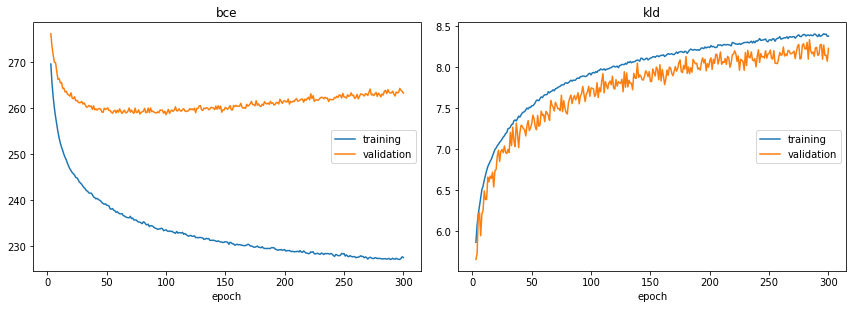

bce:
training   (min:  227.082, max:  301.572, cur:  227.515)
validation (min:  258.604, max:  286.098, cur:  263.282)

kld:
training   (min:    4.248, max:    8.406, cur:    8.378)
validation (min:    4.998, max:    8.334, cur:    8.229)


In [32]:
seed = 42
lr = 1e-3
batch_size = 128
test_batch_size = 1024
n_epochs = 300

def train_model():
    #set_seed(42)
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

    min_loss = 1e6-1
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_kld = train(model, optimizer, train_loader)

        logs['' + 'bce'] = train_loss.item()
        logs['' + 'kld'] = train_kld.item()

        validation_loss, validation_kld = validate(model, test_loader)
        logs['val_' + 'bce'] = validation_loss.item()
        logs['val_' + 'kld'] = validation_kld.item()

        liveloss.update(logs)
        liveloss.draw()

        #Store best validation loss model
        if validation_loss < min_loss:
            torch.save(model.state_dict(), F"/content/gdrive/My Drive/models/mnist_vae_"+str(epoch)+".pth")
            min_loss = validation_loss
      
    return model

model = train_model()

In [34]:

model = VAE()
model.load_state_dict(torch.load(F"/content/gdrive/My Drive/models/mnist_vae_99.pth"))
model.eval()

VAE(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3_mu): Linear(in_features=256, out_features=2, bias=True)
  (linear3_logvar): Linear(in_features=256, out_features=2, bias=True)
  (linear4): Linear(in_features=2, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
  (sigmoid): Sigmoid()
)

In [35]:
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0) # also have this
xs, zs = evaluate(model.to(device), test_loader)
print(xs.shape, zs.shape)

(10000, 1, 28, 28) (10000, 2)


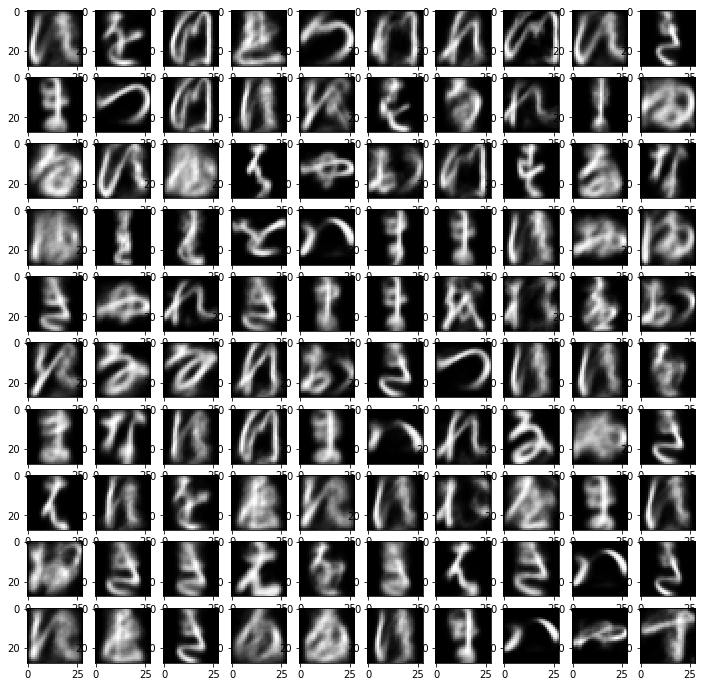

In [36]:
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), xs[0:100, 0]):
  ax.imshow(img, cmap="gray")

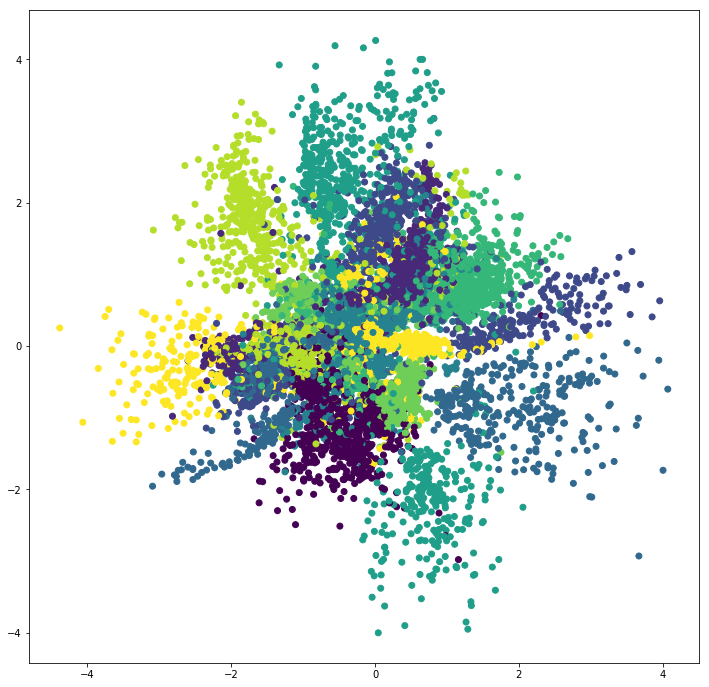

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(zs[:, 0], zs[:, 1], c=mnist_test_dset.targets)

In [0]:
class VAEnet(nn.Module):
    def __init__(self, trained_model):
        super(VAEnet, self).__init__()
        
        
        self.trained_model = trained_model
        for param in self.trained_model.parameters():
            param.requires_grad = False # hopefully stops retraining.
        
        
        
        
        
        
        
        # three hidden layers
        self.linear1 = nn.Linear(30, 20)
        self.linear2 = nn.Linear(20, 10)
#         self.linear3 = nn.Linear(24, 10)
        # 
        
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
#    
    def forward(self, x):
        
#         mu, log_var = self.encoder(x.view(-1, 784))
        
        z, _ = self.trained_model.encode(x.view(-1, 784))
        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        return z
        
        

# build model
# x = torch.randn((1, 1, 28, 28)).to(device)
# model = VAE().to(device)
# x_, z, mu, logvar = model(x)
# print(x_.size(), z.size(), mu.size(), logvar.size())
new_model = VAEnet(model)

In [0]:
# mnist_train_dset = KMNIST("./", download=True, train=True)
# mnist_test_dset = KMNIST("./", download=True, train=False)

def load_data():
    '''Separate so we can load all the data at the end and train on validation'''
    X = np.load(F"/content/gdrive/My Drive/datasets/kmnist-train-imgs.npy")
    y = np.load(F"/content/gdrive/My Drive/datasets/kmnist-train-labels.npy")
    return X, y

X, y = load_data()

def split(valid_frac):
    '''
    Load stratified split
    
    valid_frac is fraction of training set used for validation set
        Can be fine tuned
    '''
    X, y = load_data()
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=valid_frac)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_valid, y_valid = split(0.1)

def apply_normalization(X):
    mean = X.mean()
    std = X.std()
    X = X - mean  # take away the mean
    X = X / std  # divide by the std
    return X


# X_test = np.load(F"/content/gdrive/My Drive/datasets/kmnist-test-imgs.npy")
# # X_test = apply_normalization(X_test)
# X_test = torch.FloatTensor(X_test).view(-1, 1, 28,28)


X_train = apply_normalization(X_train)
X_valid = apply_normalization(X_valid)


X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)
mnist_train = TensorDataset(X_train, y_train)
mnist_validate = TensorDataset(X_valid, y_valid)





# mnist_train = CustomVAETensorDataset(mnist_train_dset.train_data)
# mnist_test = CustomVAETensorDataset(mnist_test_dset.test_data)





# NEW TRAINING FUNCS


In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))

In [41]:
# initialise model outside.
# need to look at the validation split- havent split it/. 

def new_train_model(momentum, model):
  set_seed(seed)
#   model = LeNet5().to(device)
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader) # changed this. 
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = new_train_model(0.5, new_model)

AttributeError: ignored